# Basic Workflow 2: NetworkX and Cytoscape


by [Keiichiro Ono](http://keiono.github.io/)


----

![](http://cytoscape.org/images/logo/cy3logoOrange.svg)


## Introduction
Welcome to the part 2 of basic tutorial.  In this example, you will learn how to use Cytoscape with NetworkX, a very poweful network analysis toolkit.

### Libraries used in this tutorial
* resuests
* json
* networkx
* bokeh
* numpy
* pandas
* py2cytoscape

Be sure to run
```
pip install -U requests
pip install -U networkx
pip install -U bokeh
pip install -U numpy
pip install -U pandas
pip install -U py2cytoscape
```

----
## Questions or Feature Requests?
Please send them to our [mailing list](https://groups.google.com/forum/#!forum/cytoscape-discuss)


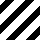
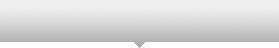
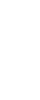
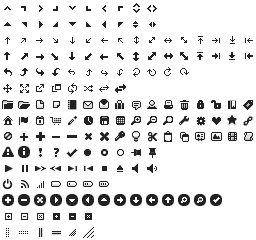
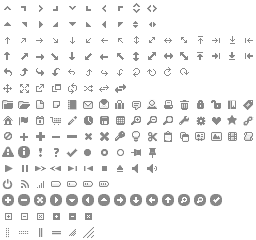
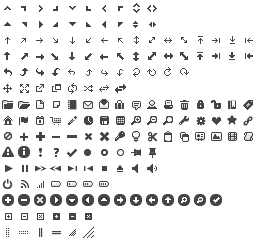
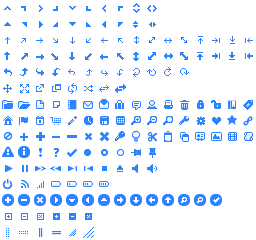
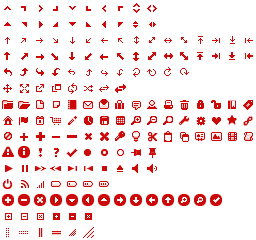
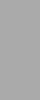
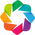
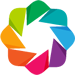
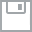
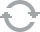
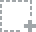
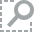
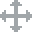
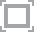
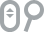

<Response [200]>

In [1]:
import requests
import json
import networkx as nx
from IPython.display import Image

# Library for util
from py2cytoscape import util as cy 

from collections import OrderedDict
import numpy as np
from bokeh.charts import Bar
from bokeh.plotting import *

output_notebook()

import pandas as pd

# Basic Setup
PORT_NUMBER = 1234

#IP = '192.168.1.1'
IP = 'localhost'

BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

# Delete all networks in current session
requests.delete(BASE + 'session')

## POST Cytoscape.js JSON file
It is easy to post local JSON file to Cytoscape.

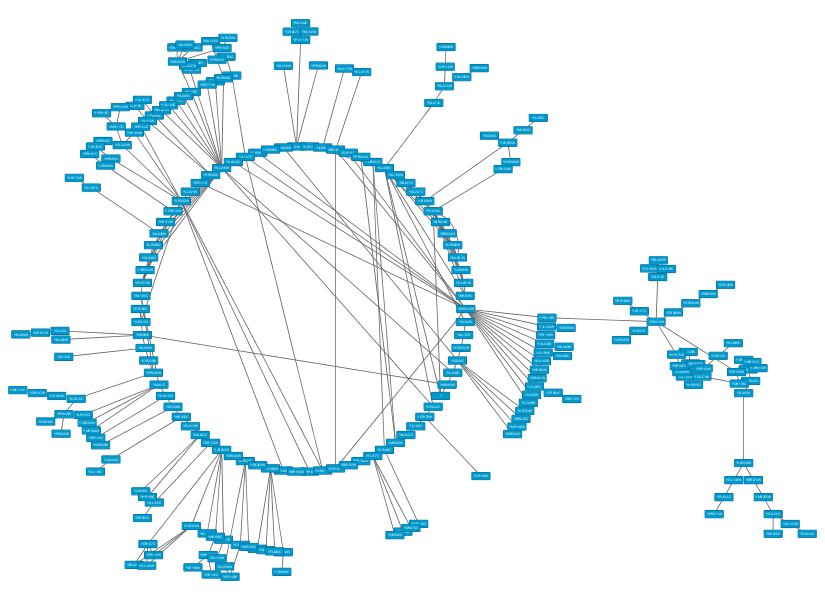

In [2]:
# Create dictionary object from JSON file
f = open('sample_data/yeast.json', 'r')
jsonData = json.load(f)

# Set network name
jsonData['data']['name'] = 'Yeast Sample 1' 

# print(json.dumps(jsonData, indent=4))

res1 = requests.post(BASE + 'networks', data=json.dumps(jsonData), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## Create a small network with NetworkX
First, let's make a small network manually with NetworkX.

Number of Nodes = 3
Number of Edges = 4


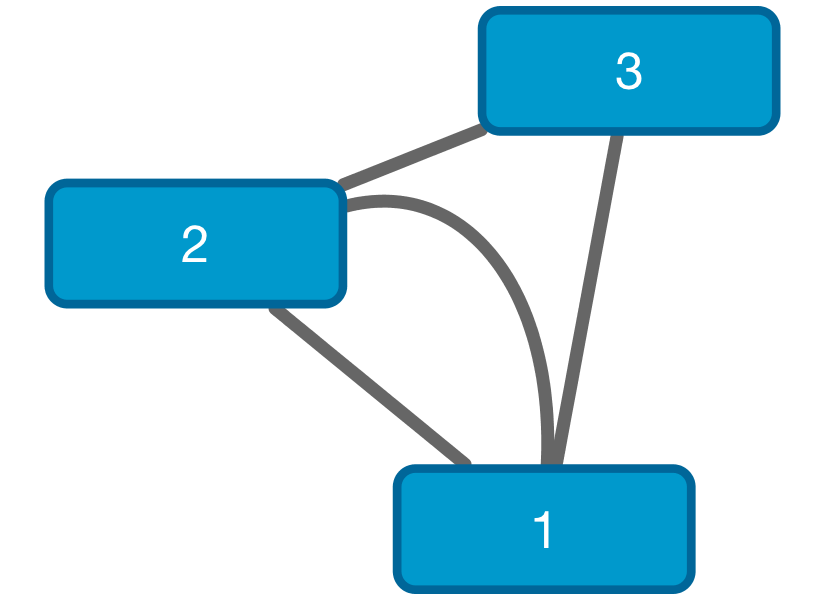

In [3]:
g = nx.MultiDiGraph()
g.add_node(1)
g.add_node(2)
g.add_node(3)

g.add_edge(1, 2)
g.add_edge(2, 1)
g.add_edge(1, 3)
g.add_edge(3, 2)

print('Number of Nodes = ' + str(g.number_of_nodes()))
print('Number of Edges = ' + str(g.number_of_edges()))

# Convert NetworkX Graph object 
cytoscape_network = cy.from_networkx(g)

res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## Generate graph with NetworkX

100
226


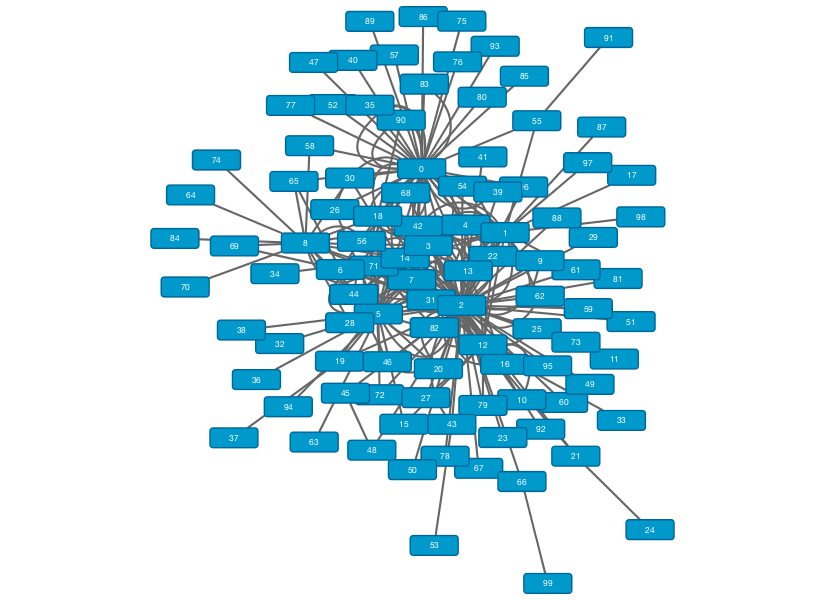

In [4]:
scale_free_graph = nx.scale_free_graph(100)
scale_free_graph.graph['name'] = 'Scale-Free Graph'

print(scale_free_graph.number_of_nodes())
print(scale_free_graph.number_of_edges())

res1 = requests.post(BASE + 'networks', data=json.dumps(cy.from_networkx(scale_free_graph)), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## Generate Networks with NetworkX

### Generate random networks
In the [first tutorial](http://localhost:8888/notebooks/basic/CytoscapeREST_Basic1.ipynb), you learned how to generate networks programmatically, and send them to Cytoscape.  However, there are better ways to manage network data in Python.  Using NetworkX is one of the most popular network analysis toolkit in Python.  Let's generate some network data with NetworkX.

#### Graph generators in NetworkX
NetworkX comes with several graph generators.  Let's make some networks using defferent modlels.

In [5]:
graphs = {}
NUMBER_OF_NODES = 100

# Scale-Free
graphs['scale-free']= nx.scale_free_graph(NUMBER_OF_NODES);

# Complete
graphs['complete'] = nx.complete_graph(NUMBER_OF_NODES)

# Circular Ladder
graphs['circular ladder'] = nx.circular_ladder_graph(NUMBER_OF_NODES)

# Small-World
graphs['small world'] = nx.watts_strogatz_graph(NUMBER_OF_NODES, 4, 0.1)

# Binominal
graphs['binominal'] = nx.binomial_graph(NUMBER_OF_NODES, 0.3)

# Real-world example: 
graphs['real social network'] = nx.karate_club_graph()

In [6]:
for key in graphs.keys():
    g = graphs[key]
    # Perform simple graph analysis
    
    # Node statistics
    bc = nx.betweenness_centrality(g)
    degree = nx.degree(g)
    cc = nx.closeness_centrality(g)
    nx.set_node_attributes(g, 'betweenness', bc)
    nx.set_node_attributes(g, 'closeness', cc)
    nx.set_node_attributes(g, 'degree', degree)
    
    # Network statistics
    g.graph["avg_shortest_path_len"] = nx.average_shortest_path_length(g)
    g.graph["density"] = nx.density(g)

## Network Statistics
Of course, you can see the overall characteristics of the networks with traditional chart visualization tools in Python.  In this example, we use [Bokeh](http://bokeh.pydata.org/) library to draw some charts.

In [7]:
graph_names= list(graphs.keys())

density_list = list(map( lambda x: x.graph["density"] ,graphs.values()))

dl = np.array(density_list, dtype=np.float)
den = {'Graph Density': dl}

density = Bar(den, graph_names, title="Network Density", xlabel="Network Name", ylabel="Density", legend=True, width=900, height=500, notebook=True)

sp_list = list(map( lambda x: x.graph["avg_shortest_path_len"] ,graphs.values()))
sp = np.array(sp_list, dtype=np.float)

shortest_path = {'Average Shortest Path Length': sp}
path_length = Bar(shortest_path, graph_names, title="Average Shortest Path Length", xlabel="Network Name", ylabel="Length", 
          legend=True, width=900, height=500, notebook=True)

# Draw the chart
density.show()
path_length.show()

## Visualization with Cytoscape
Chart is a good way to understand basic nature of your graphs.  However, it is more helpful to see the actual connections as node-link diagrams especially for networks of this size.  Let's do it in Cytoscape.

### Send all network models to Cytoscape
Converting NetworkX object into Cytoscape.js style JSON is straightforward, but to save your time, we will release cytoscape module available from PyPI.  __Currently, it is not released yet, and is available in this example directory__. 

Now let's visualize them.

In [8]:
# Remove all networks
requests.delete(BASE + 'networks')

# Map from human readable network name to Cytoscape network ID.
name2suid = {}

network_images = []

for key in graphs.keys():
    g = graphs[key]
    cyjs_network = cy.from_networkx(g)
    #print(json.dumps(cyjs_network, indent=4))
    cyjs_network['data']['name'] = key
    res1 = requests.post(BASE + 'networks', data=json.dumps(cyjs_network), headers=HEADERS)
    suid_res = res1.json()
    suid = suid_res['networkSUID']
    name2suid[key] = suid
    requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
    requests.get(BASE + 'apply/styles/Directed/' + str(suid))
    network_images.append(Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True))

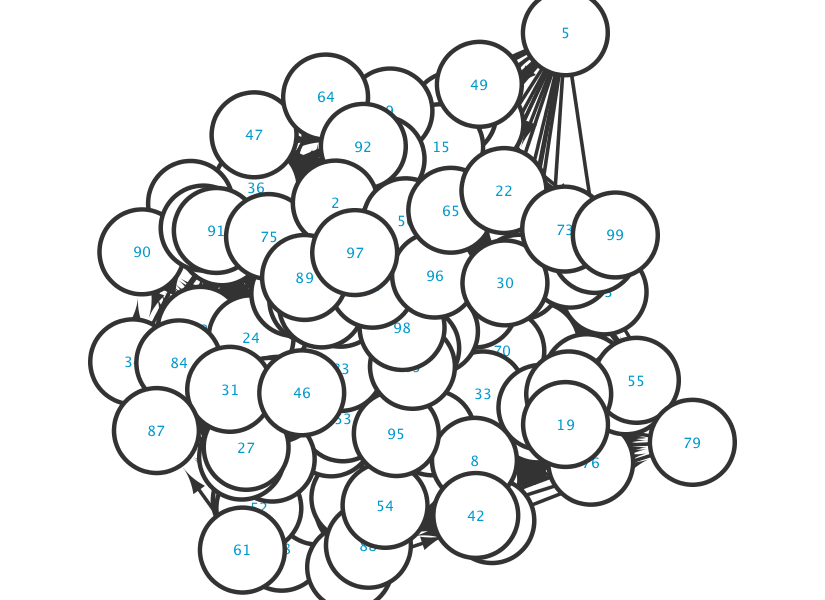

In [9]:
network_images[0]

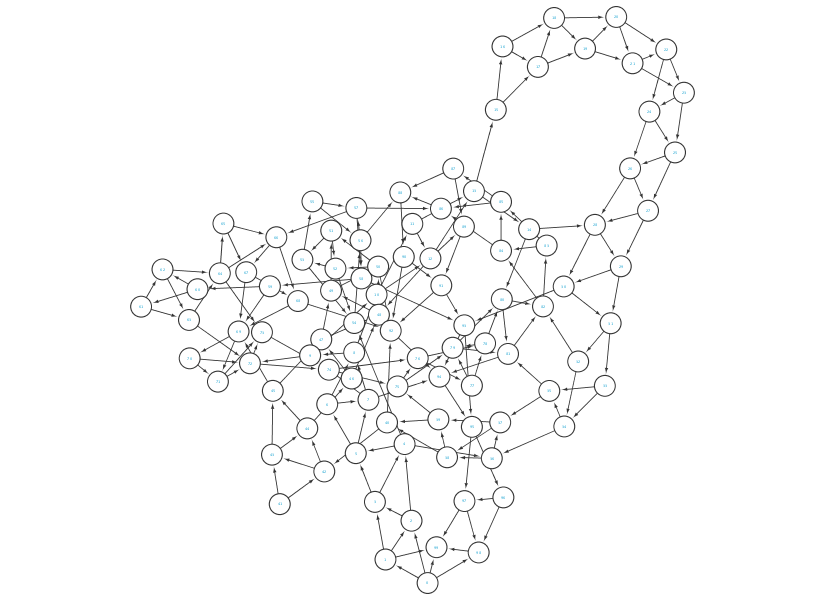

In [10]:
network_images[5]

It depends on your Cytoscape settings, but now you can see something like this:

![](../images/basic2-1.png)

## Get your data from Cytoscape
In some cases, you may want to perform analysis on data sets saved in Cytoscape session.  It is easy to get the data from Cytoscape.  Let's try to get a network from Cytoscape.

In [11]:
# As long as you use the same Cytoscape session, ID (SUID) is same.
scale_free_network_id = name2suid['scale-free']

# Fetch the data from Cytoscape (as JSON)
res2 = requests.get(BASE + 'networks/' + str(scale_free_network_id) + "/views/first")

# Convert to Python object
network = res2.json()

# make DataFrame from node list
nodes = network['elements']['nodes']
node_df = pd.DataFrame(nodes)
node_df.head()

,data,position,selected
0,"{u'name': u'99', u'degree': 1.0, u'SUID': 4394...","{u'y': 41.1841117477, u'x': 235.856154442}",False
1,"{u'name': u'98', u'degree': 1.0, u'SUID': 4394...","{u'y': -21.3108833694, u'x': -341.48631382}",False
2,"{u'name': u'97', u'degree': 1.0, u'SUID': 4394...","{u'y': 292.837645683, u'x': -447.011429787}",False
3,"{u'name': u'96', u'degree': 1.0, u'SUID': 4394...","{u'y': 77.4659415817, u'x': -229.157364845}",False
4,"{u'name': u'95', u'degree': 1.0, u'SUID': 4394...","{u'y': 164.76800457, u'x': 222.840743065}",False


And you can use py2cytoscape utility function to convert Cytoscape.js JSON back to NetworkX object.

In [12]:
nx_network = cy.to_networkx(network)
print("Network Name is: " + nx_network.name)

Network Name is: scale-free


In [13]:
# Getting table as CSV is simple
table_url = BASE + 'networks/' + str(scale_free_network_id) + "/tables/defaultnode.csv"

# Or as TAB delimited text table
#table_url = BASE + 'networks/' + str(scale_free_network_id) + "/tables/defaultnode.tsv"

# Let's convert it to Pandas DataFrame
table_df = pd.read_csv(table_url)
table_df.head(10)

,SUID,shared name,betweenness,closeness,id,degree,name,selected,club
0,43846,0,0.036951,0.059418,0,48,0,False,NaN
1,43847,1,0.025390,0.063131,1,28,1,False,NaN
2,43848,2,0.034409,0.056117,2,80,2,False,NaN
3,43849,3,0.003298,0.040404,3,11,3,False,NaN
4,43850,4,0.000000,0.000000,4,8,4,False,NaN
5,43851,5,0.000000,0.074220,5,23,5,False,NaN
6,43852,6,0.000000,0.000000,6,43,6,False,NaN
7,43853,7,0.000000,0.058182,7,12,7,False,NaN
8,43854,8,0.000000,0.073326,8,15,8,False,NaN
9,43855,9,0.000000,0.043651,9,2,9,False,NaN


# New in 1.x: Batch vector image genration

You can easily create veator graphics files from these networks.  In addition to PNG, cyREST supports the following formats:

* SVG
* PDF

## Sample 1: Create PDF file for each network in the current session

In [14]:
import urllib
import os, sys

ver = sys.version_info.major


def save_networks_as_image(networks, target_dir, file_format='pdf'):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for suid in networks:
        network_table_url = BASE + 'networks/' + str(suid) +'/tables/defaultnetwork/rows'
        res = requests.get(network_table_url).json()
        network_row = res[0]
        network_name = network_row['name']
        image_url = BASE+'networks/' + str(suid) + '/views/first.' + file_format
        if ver == 3:
            res = urllib.request.urlretrieve (image_url, os.path.join(target_dir, network_name + '.' + file_format))
        else:
            res = urllib.urlretrieve (image_url, os.path.join(target_dir, network_name + '.' + file_format))


# Target directory: by default. it's  current dir.
target_dir = "network_images"

networks_url = BASE + 'networks/'
networks = requests.get(networks_url).json()

save_networks_as_image(networks, target_dir)

This code generates PDF file for each network.  Check [network_images](network_images) directory to see the result.


## Sample 2: Generate a simple web page with SVG images

___Make sure you have [BeautifulSoup4](http://www.crummy.com/software/BeautifulSoup/bs4/doc/)!___

It is easy to create simple web pages with SVG network images with cyREST and Python!

In [15]:
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup

web_dir = "web_page"
save_networks_as_image(networks, web_dir, file_format='svg')

soup = BeautifulSoup('<!DOCTYPE html><html><body><h1 align="center">Cytoscpae Session as a Web Page</h1><div class="images" align="center"></div></body></html>')

svg_files = [f for f in listdir(web_dir) if isfile(join(web_dir,f))]

for svg_file in svg_files:
    if svg_file.endswith('html'):
        continue    
    new_tag = soup.new_tag('img', src=svg_file, width="1000")
    title = soup.new_tag('h2')
    title.append(svg_file)
    soup.div.append(title)
    soup.div.append(new_tag)

result = str(soup)

with open(os.path.join(web_dir, 'index.html'), "w") as html_file:
    html_file.write(result)

# Now the result is in the "web_page" folder.

# If you are NOT a mac user, comment-out the following.
!open web_page/index.html

### Sample output is available [here](http://chianti.ucsd.edu/~kono/webapp/cyrest-python-basic2-svg/)

----
[Back to Index](../index.ipynb)